In [0]:
df = spark.read.json("abfss://output@mahibasupplychainadls.dfs.core.windows.net/api_data/demand-data")
df.show(truncate=False)
df.printSchema()


+-----------------+----------+------------+----------+----------------+-------------+------+-------+----------+--------+
|Daily_Usage_Units|Date      |Downtime_Min|Econ_Index|Peak_Usage_Units|Region       |Season|Service|Storage_TB|VM_Count|
+-----------------+----------+------------+----------+----------------+-------------+------+-------+----------+--------+
|67008            |01-01-2020|0           |88        |82228           |East US      |Winter|Compute|0         |6467    |
|0                |01-01-2020|1           |100       |0               |East US      |Winter|Storage|461       |0       |
|127251           |01-01-2020|2           |104       |135018          |West Europe  |Winter|Compute|0         |6019    |
|0                |01-01-2020|2           |94        |0               |West Europe  |Winter|Storage|1018      |0       |
|61531            |01-01-2020|0           |91        |74826           |Central India|Winter|Compute|0         |9029    |
|0                |01-01-2020|1 

In [0]:
df = spark.read.text("abfss://output@mahibasupplychainadls.dfs.core.windows.net/snowflake_data/external_factors.csv")
df.show(truncate=False)


+-------------------------------------------------------------------+
|value                                                              |
+-------------------------------------------------------------------+
|Date,Cloud_Demand_Index,GDP_Growth,Inflation,Competitor_Price_Index|
|2020-01-01,67,3.727301838650201,4.200878600524534,120              |
|2020-01-02,77,4.657382372114083,3.6821822305513994,129             |
|2020-01-03,89,2.910710224528352,5.363531613888448,93               |
|2020-01-04,93,2.6926987037504917,3.7983149076244174,115            |
|2020-01-05,88,4.488592563558635,7.5169760885293915,98              |
|2020-01-06,84,5.022146010034563,3.0655951605785035,114             |
|2020-01-07,96,3.852970938517362,4.290569935528852,124              |
|2020-01-08,101,2.44401672312273,4.970925480972137,104              |
|2020-01-09,82,5.648551957397496,5.276924836157606,107              |
|2020-01-10,115,5.248756131504405,6.6494943110654745,121            |
|2020-01-11,91,2.505

In [0]:
df = spark.read.text("abfss://output@mahibasupplychainadls.dfs.core.windows.net/gcp_data/feature_engineering_data.csv")
df.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Date,Region,Service,Daily_Usage_Units,Peak_Usage_Units,VM_Count,Storage_TB,Season,Econ_Index,Downtime_Min,Usage_Lag_1,Usage_Lag_7,Week_Over_Week_Growth,Seasonality_Factor|
|2020-01-01,East US,Compute,67008,82228,6467,0,Winter,88,0,,,,1.0858207542704796                                                                                           |
|2020-01-02,East US,Compute,119766,147059,14375,0,Winter,90,1,67008.0,,,1.0670241792350095                                             

Bronze datasets saved to: abfss://output@mahibasupplychainadls.dfs.core.windows.net/bronze/


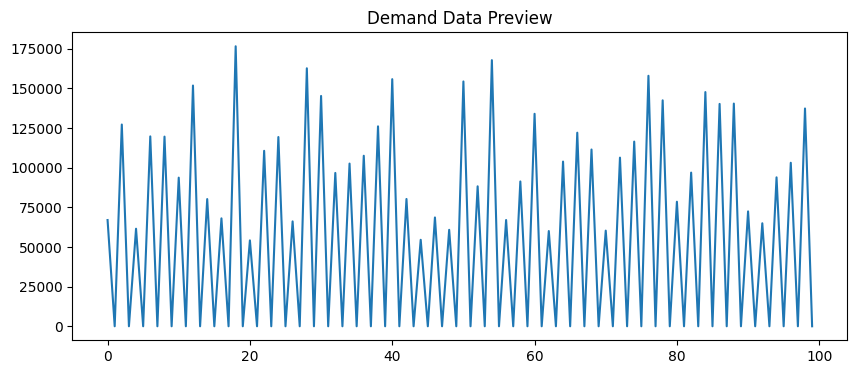

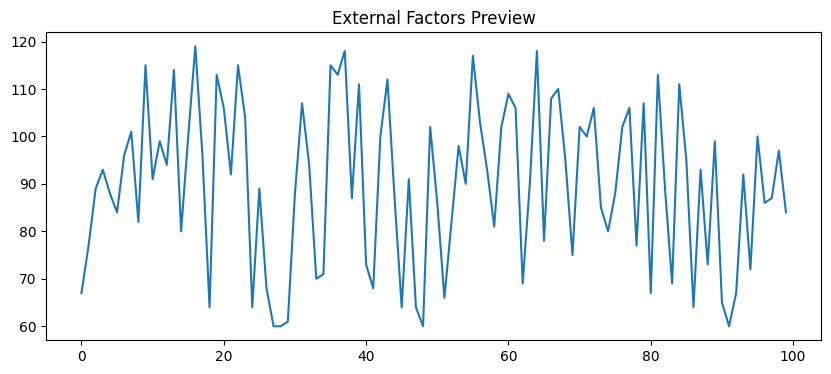

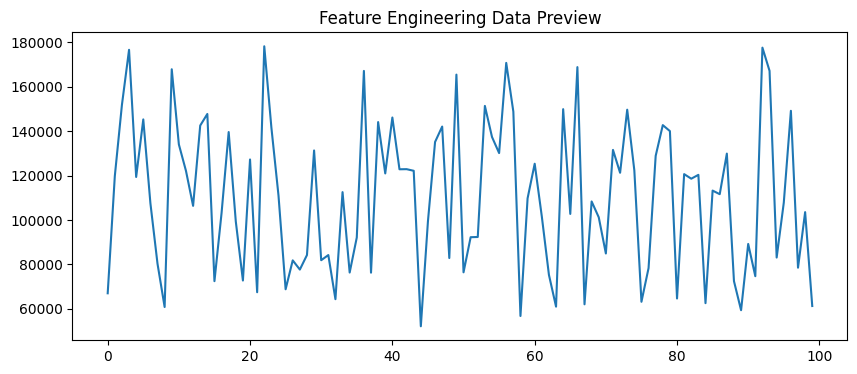

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

DEMAND_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/api_data/demand-data"
EXTERNAL_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/snowflake_data/external_factors.csv"
FEATENG_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/gcp_data/feature_engineering_data.csv"

BRONZE_PATH = "abfss://output@mahibasupplychainadls.dfs.core.windows.net/bronze/"

# -------- LOAD DATA --------

def load_csv(path):
    return spark.read.option("header", True).option("inferSchema", True).csv(path)

def load_json(path):
    return spark.read.option("multiline", "true").json(path)

demand = load_json(DEMAND_PATH)
external = load_csv(EXTERNAL_PATH)
feateng = load_csv(FEATENG_PATH)

# -------- WRITE RAW DATA TO BRONZE --------

demand.write.mode("overwrite").json(BRONZE_PATH + "demand")
external.write.mode("overwrite").option("header", True).csv(BRONZE_PATH + "external")
feateng.write.mode("overwrite").option("header", True).csv(BRONZE_PATH + "feateng")

print("Bronze datasets saved to:", BRONZE_PATH)

# -------- PREVIEW DATA IN NOTEBOOK --------

pdf_demand = demand.limit(500).toPandas()
pdf_external = external.limit(500).toPandas()
pdf_feateng = feateng.limit(500).toPandas()

# -------- INLINE NOTEBOOK PLOTS --------

def show_plot(df, name):
    numeric_cols = df.select_dtypes(include=["number"]).columns
    if len(numeric_cols) == 0:
        print(f"No numeric columns in {name}")
        return

    plt.figure(figsize=(10,4))
    df[numeric_cols[0]].head(100).plot(title=f"{name} Preview")
    plt.show()

show_plot(pdf_demand, "Demand Data")
show_plot(pdf_external, "External Factors")
show_plot(pdf_feateng, "Feature Engineering Data")
